In [4]:
import itertools, copy, json, random, torch, timm, torch.nn as nn
from torch.utils.data import DataLoader

from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score
import numpy as np

from torchvision import datasets, transforms
from pathlib import Path
from collections import Counter

import pandas as pd, pprint, json
import matplotlib.pyplot as plt
from pathlib import Path

In [5]:
class CFG:
    # --- utils ---
    seed          = 42
    train         = True
    inference     = False

    # --- data ---
    LABELS        = ["Unripe", "Early Ripening", "Ripe", "Fully Ripe", "Overripe"]
    batch_size    = 32            # default 32 fits 299² on 8 GB GPU; tune in your grid search
    img_size      = 299           # Inception V3 native input
    num_classes   = len(LABELS)
    input_channels= 3
    mean          = (0.485, 0.456, 0.406)   # ImageNet
    std           = (0.229, 0.224, 0.225)

    # --- training ---
    epochs        = 50

  
  
    # --- device ---
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # --- model ---
    base_model    = 'inception_v3'          # torchvision name
    weight        = 'IMAGENET1K_V1'         # matches torchvision tag


### Setting Up the Search Space

In [6]:

SEARCH = {
    "optimizer": ["Adam", "SGD", "Adagrad"],
    "lr"       : [1e-3, 5e-3, 1e-4],
    "loss_fn"  : ["CrossEntropy", "WeightedCrossEntropy"],
    "batch_size": [16, 32, 64]
}

def expand_grid(search_dict):
    keys, values = zip(*search_dict.items())
    for v in itertools.product(*values):
        yield dict(zip(keys, v))


### Utility 
build → train → eval for one run

In [7]:
def build_model(cfg):
    model = timm.create_model(cfg.base_model, pretrained=True, num_classes=cfg.num_classes)
    return model.to(cfg.device)

def make_criterion(cfg, class_count):
    if cfg.loss_fn == "CrossEntropy":
        return nn.CrossEntropyLoss()
    elif cfg.loss_fn == "WeightedCrossEntropy":
        # crude weight: 1 / freq
        counts = torch.tensor(class_count, dtype=torch.float32)
        weights = (1.0 / counts) * len(counts) / counts.sum()
        return nn.CrossEntropyLoss(weight=weights.to(cfg.device))

def make_optimizer(cfg, model):
    if cfg.optimizer == "Adam":
        return torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)
    if cfg.optimizer == "SGD":
        return torch.optim.SGD(model.parameters(), lr=cfg.lr,
                               momentum=cfg.momentum, weight_decay=cfg.wd)
    if cfg.optimizer == "Adagrad":
        return torch.optim.Adagrad(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)


### Training Loop - Condensed

In [8]:
USE_CUDA = torch.cuda.is_available()
scaler   = GradScaler(enabled=USE_CUDA)

def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    loss_meter = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        with autocast(enabled=USE_CUDA):
            logits = model(X)
            loss   = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_meter += loss.item() * X.size(0)

    return loss_meter / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    for X, y in loader:
        X = X.to(device)
        logits = model(X)
        y_true += y.tolist()
        y_pred += logits.argmax(1).cpu().tolist()
    return accuracy_score(y_true, y_pred)

### Hook it All Together

In [9]:

DATA_ROOT = Path("./data/processed_data/")
SEED = CFG.seed
torch.manual_seed(SEED)
random.seed(SEED)

# constant transforms (resize to cfg.img_size)
# From size 224x224 to 299x299 for suit InceptionV3
train_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(CFG.mean, CFG.std)
])
val_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(CFG.mean, CFG.std)
])

full_ds = datasets.ImageFolder(DATA_ROOT, transform=train_tf)
class_hist = Counter([y for _, y in full_ds])

# simple 80 / 20 split
val_len = int(0.2 * len(full_ds))
train_len = len(full_ds) - val_len
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_len, val_len])
val_ds.dataset.transform = val_tf


In [10]:
results = []

for hp in expand_grid(SEARCH):
    cfg = copy.deepcopy(CFG)
    for k, v in hp.items():
        setattr(cfg, k, v)
    print("⟹ Run:", hp)

    pin_mem = torch.cuda.is_available()
    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size,
                              shuffle=True,  num_workers=cfg.num_workers, pin_memory=pin_mem)
    val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size,
                              shuffle=False, num_workers=cfg.num_workers, pin_memory=pin_mem)

    model      = build_model(cfg)
    criterion  = make_criterion(cfg, [class_hist[i] for i in range(cfg.num_classes)])
    optimizer  = make_optimizer(cfg, model)
    scaler     = GradScaler(enabled=torch.cuda.is_available())

    best_val, best_epoch = 0.0, -1
    for epoch in range(cfg.epochs):
        _ = train_one_epoch(model, train_loader, criterion,
                            optimizer, scaler, cfg.device)
        val_acc = evaluate(model, val_loader, cfg.device)

        if val_acc > best_val:
            best_val, best_epoch = val_acc, epoch

        # early-stop after 8 epochs with no gain
        if epoch - best_epoch > 8:
            break

    results.append({**hp, "val_acc": best_val})

⟹ Run: {'optimizer': 'Adam', 'lr': 0.001, 'loss_fn': 'CrossEntropy', 'batch_size': 16}
⟹ Run: {'optimizer': 'Adam', 'lr': 0.001, 'loss_fn': 'CrossEntropy', 'batch_size': 32}
⟹ Run: {'optimizer': 'Adam', 'lr': 0.001, 'loss_fn': 'CrossEntropy', 'batch_size': 64}
⟹ Run: {'optimizer': 'Adam', 'lr': 0.001, 'loss_fn': 'WeightedCrossEntropy', 'batch_size': 16}
⟹ Run: {'optimizer': 'Adam', 'lr': 0.001, 'loss_fn': 'WeightedCrossEntropy', 'batch_size': 32}
⟹ Run: {'optimizer': 'Adam', 'lr': 0.001, 'loss_fn': 'WeightedCrossEntropy', 'batch_size': 64}
⟹ Run: {'optimizer': 'Adam', 'lr': 0.005, 'loss_fn': 'CrossEntropy', 'batch_size': 16}
⟹ Run: {'optimizer': 'Adam', 'lr': 0.005, 'loss_fn': 'CrossEntropy', 'batch_size': 32}
⟹ Run: {'optimizer': 'Adam', 'lr': 0.005, 'loss_fn': 'CrossEntropy', 'batch_size': 64}
⟹ Run: {'optimizer': 'Adam', 'lr': 0.005, 'loss_fn': 'WeightedCrossEntropy', 'batch_size': 16}
⟹ Run: {'optimizer': 'Adam', 'lr': 0.005, 'loss_fn': 'WeightedCrossEntropy', 'batch_size': 32}
⟹ R

In [11]:

df = pd.DataFrame(results).sort_values("val_acc", ascending=False)
print(df.head(10))
best_cfg = df.iloc[0].to_dict()
print("\nBest combo:", best_cfg)
df.to_csv("inceptionv3_results.csv", index=False)


   optimizer      lr               loss_fn  batch_size  val_acc
36   Adagrad  0.0010          CrossEntropy          16      1.0
33       SGD  0.0001  WeightedCrossEntropy          16      1.0
39   Adagrad  0.0010  WeightedCrossEntropy          16      1.0
28       SGD  0.0050  WeightedCrossEntropy          32      1.0
26       SGD  0.0050          CrossEntropy          64      1.0
25       SGD  0.0050          CrossEntropy          32      1.0
42   Adagrad  0.0050          CrossEntropy          16      1.0
24       SGD  0.0050          CrossEntropy          16      1.0
22       SGD  0.0010  WeightedCrossEntropy          32      1.0
13      Adam  0.0001          CrossEntropy          32      1.0

Best combo: {'optimizer': 'Adagrad', 'lr': 0.001, 'loss_fn': 'CrossEntropy', 'batch_size': 16, 'val_acc': 1.0}


,optimizer,lr,loss_fn,batch_size,val_acc
0,Adagrad,0.0010,CrossEntropy,16,1.000000
1,SGD,0.0001,WeightedCrossEntropy,16,1.000000
2,Adagrad,0.0010,WeightedCrossEntropy,16,1.000000
3,SGD,0.0050,WeightedCrossEntropy,32,1.000000
4,SGD,0.0050,CrossEntropy,64,1.000000
5,SGD,0.0050,CrossEntropy,32,1.000000
6,Adagrad,0.0050,CrossEntropy,16,1.000000
7,SGD,0.0050,CrossEntropy,16,1.000000
8,SGD,0.0010,WeightedCrossEntropy,32,1.000000
9,Adam,0.0001,CrossEntropy,32,1.000000


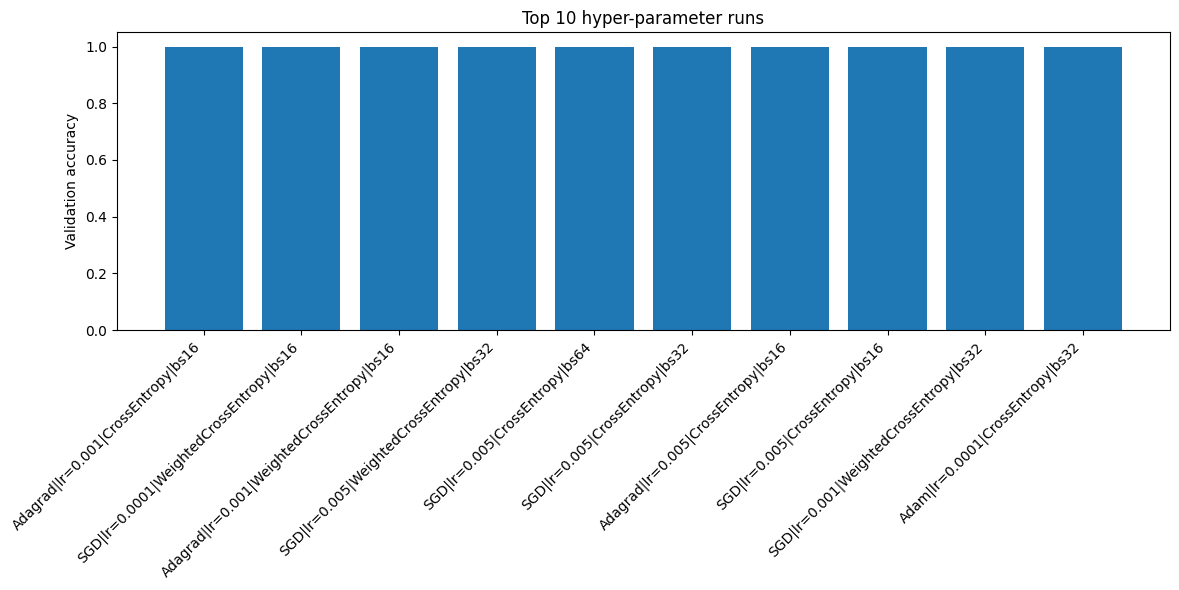


 Best run:
optimizer          Adagrad
lr                   0.001
loss_fn       CrossEntropy
batch_size              16
val_acc                1.0


In [12]:

# -------------------------------
# 1) list-of-dicts  ➜  DataFrame
# -------------------------------
df = pd.DataFrame(results)           # results must still be in memory
df_sorted = df.sort_values("val_acc", ascending=False).reset_index(drop=True)

# --------------------------------
# 2) show the full table in Jupyter
# --------------------------------
display(df_sorted)


# --------------------------------
# 4) quick bar chart of top-N runs
# --------------------------------
top_n = 10
plt.figure(figsize=(12, 6))
bars = plt.bar(range(top_n), df_sorted["val_acc"][:top_n])
plt.xticks(range(top_n),
           [f"{r.optimizer}|lr={r.lr}|{r.loss_fn}|bs{r.batch_size}"
            for _, r in df_sorted.head(top_n).iterrows()],
           rotation=45, ha="right")
plt.ylabel("Validation accuracy")
plt.title(f"Top {top_n} hyper-parameter runs")
plt.tight_layout()
plt.show()

# --------------------------------
# 5) print the single best config
# --------------------------------
best = df_sorted.iloc[0]
print("\n Best run:")
print(best.to_string())

In [13]:
torch.save(model.state_dict(), "last_model.pt")